In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import entropy

from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

import os
os.makedirs("results_softmax_analysis", exist_ok=True)

In [13]:
def load_testset(path='simulation_data/', string='M1_M20'):
    if not path.endswith('/'):
        path += '/'
    filenames = ['x1_test', 'x2_test', 'y_test']
    data = []
    for file_name in filenames:
        file_path = path + file_name + '_' + string + '.pkl'
        with open(file_path, 'rb') as f:
            arr = pickle.load(f)
            data.append(np.array(arr))
    return data

x1_test, x2_test, y_test = load_testset(path='simulation_data/', string='M1_M20')
y_true = y_test.argmax(axis=1) if y_test.ndim == 2 else y_test.astype(int).ravel()

print("x1_test shape:", x1_test.shape)
print("x2_test shape:", x2_test.shape)
print("y_test shape:", y_test.shape)

x1_test shape: (100000, 4)
x2_test shape: (100000, 7, 12)
y_test shape: (100000, 20)


In [3]:
def generate_results(model_path, out_name, x1_test, x2_test):
    model = load_model(model_path, compile=False)
    model.compile(optimizer=Adam(), loss=CategoricalCrossentropy())
    mean_probs = model.predict([x1_test, x2_test])
    entropies = entropy(mean_probs.T).T
    def credible_set(probs, threshold=0.95):
        idx = np.argsort(probs)[::-1]
        cumsum = np.cumsum(probs[idx])
        k = np.searchsorted(cumsum, threshold) + 1
        return idx[:k]
    credible_sets = [credible_set(p, 0.95) for p in mean_probs]
    out_path = os.path.join("results_softmax_analysis", out_name)
    np.savez(out_path,
             mean_probs=mean_probs,
             entropies=entropies,
             credible_sets=np.array(credible_sets, dtype=object))

generate_results('trained_model_baseline/M1_20_model_classification_baseline', 'results_softmax_analysis_baseline.npz', x1_test, x2_test)
generate_results('trained_model_attention/M1_20_model_classification_attention', 'results_softmax_analysis_attention.npz', x1_test, x2_test)
generate_results('trained_model_gatefusion/M1_20_model_classification_gatefusion', 'results_softmax_analysis_gatefusion.npz', x1_test, x2_test)
generate_results('trained_model_hadamard/M1_20_model_classification_hadamard', 'results_softmax_analysis_hadamard.npz', x1_test, x2_test)

### Overall Model Performance Comparison

In [11]:
def load_testset(path='simulation_data/', string='M1_M20'):
    if not path.endswith('/'):
        path += '/'
    filenames = ['x1_test', 'x2_test', 'y_test']
    data = []
    for file_name in filenames:
        file_path = path + file_name + '_' + string + '.pkl'
        with open(file_path, 'rb') as f:
            arr = pickle.load(f)
            data.append(np.array(arr))
    return data

x1_test, x2_test, y_test = load_testset(path='simulation_data/', string='M1_M20')
y_true = y_test.argmax(axis=1) if y_test.ndim == 2 else y_test.astype(int).ravel()

def compute_metrics_np(mean_probs, y_true):
    preds_top1 = np.argmax(mean_probs, axis=1)
    top1 = np.mean(preds_top1 == y_true)
    top3_idx = np.argpartition(mean_probs, -3, axis=1)[:, -3:]
    top3 = np.mean((top3_idx == y_true[:, None]).any(axis=1))
    p_true = mean_probs[np.arange(mean_probs.shape[0]), y_true]
    p_true = np.clip(p_true, 1e-12, 1.0)
    ce = float(-np.mean(np.log(p_true)))
    return top1, top3, ce

files = {
    "Baseline Late-Average Fusion": "results_softmax_analysis/results_softmax_analysis_baseline.npz",
    "Attention-Weighted Fusion": "results_softmax_analysis/results_softmax_analysis_attention.npz",
    "Gate-Weighted Additive Fusion": "results_softmax_analysis/results_softmax_analysis_gatefusion.npz",
    "Hadamard (Bilinear) Fusion": "results_softmax_analysis/results_softmax_analysis_hadamard.npz",
}

rows = []
for name, path in files.items():
    data = np.load(path, allow_pickle=True)
    mean_probs = data["mean_probs"]
    top1, top3, ce = compute_metrics_np(mean_probs, y_true)
    rows.append([name, top1*100, top3*100, ce])

df = pd.DataFrame(rows, columns=["Model","Top-1 Accuracy","Top-3 Accuracy","Mean Cross-Entropy Loss"])

styled_table_acc = df.style \
    .format({
        "Top-1 Accuracy": "{:.2f}%",
        "Top-3 Accuracy": "{:.2f}%",
        "Mean Cross-Entropy Loss": "{:.4f}"
    }) \
    .set_table_styles([
        {'selector': 'table', 'props': [
            ('border', '1px solid black'),
            ('border-collapse', 'collapse')
        ]},
        {'selector': 'th', 'props': [
            ('text-align', 'left'),
            ('border-top', '1px solid black'),
            ('border-bottom', '1px solid black'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'left'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'tr:last-child td', 'props': [
            ('border-bottom', '1px solid black')
        ]}
    ]) \
    .set_properties(**{'text-align': 'left'}) \
    .hide_index()

display(styled_table_acc)

Model,Top-1 Accuracy,Top-3 Accuracy,Mean Cross-Entropy Loss
Baseline Late-Average Fusion,81.41%,97.40%,1.0337
Attention-Weighted Fusion,85.31%,99.27%,0.3766
Gate-Weighted Additive Fusion,87.79%,99.58%,0.2908
Hadamard (Bilinear) Fusion,88.82%,99.87%,0.2556


### Uncertainty and Confidence Analysis

In [15]:
def load_npz(path):
    d = np.load(path, allow_pickle=True)
    return d["entropies"]

def entropy_stats(entropies):
    return float(np.mean(entropies)), float(np.median(entropies)), float(np.std(entropies))

entropy_table_rows = []
for model_name, path in files.items():
    entropies = load_npz(path)
    ent_mean, ent_med, ent_std = entropy_stats(entropies)
    entropy_table_rows.append([model_name, ent_mean, ent_med, ent_std])

entropy_df = pd.DataFrame(
    entropy_table_rows,
    columns=["Model","Entropy Mean","Entropy Median","Entropy Standard Deviation"]
)

styled_table_entropy = entropy_df.style \
    .format({
        "Entropy Mean": "{:.6f}",
        "Entropy Median": "{:.6f}",
        "Entropy Standard Deviation": "{:.6f}"
    }) \
    .set_table_styles([
        {'selector': 'table', 'props': [
            ('border', '1px solid black'),
            ('border-collapse', 'collapse')
        ]},
        {'selector': 'th', 'props': [
            ('text-align', 'left'),
            ('border-top', '1px solid black'),
            ('border-bottom', '1px solid black'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'left'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'tr:last-child td', 'props': [
            ('border-bottom', '1px solid black')
        ]}
    ]) \
    .set_properties(**{'text-align': 'left'}) \
    .hide_index()

display(styled_table_entropy)

Model,Entropy Mean,Entropy Median,Entropy Standard Deviation
Baseline Late-Average Fusion,2.023995,1.992812,0.160904
Attention-Weighted Fusion,0.496192,0.368457,0.453144
Gate-Weighted Additive Fusion,0.382881,0.188617,0.423306
Hadamard (Bilinear) Fusion,0.313845,0.110076,0.384534


In [17]:
def load_credible_sets(path):
    d = np.load(path, allow_pickle=True)
    return d["credible_sets"]

def credible_set_sizes(credible_sets):
    return np.array([len(cs) for cs in credible_sets], dtype=int)

def proportions_for_sizes(sizes, max_show=5):
    counts = np.bincount(sizes)
    total = sizes.size
    row = []
    for k in range(1, max_show+1):
        v = counts[k] / total if k < counts.size else 0.0
        row.append(v)
    rest = np.sum(counts[max_show+1:]) / total if counts.size > max_show+1 else 0.0
    row.append(rest)
    return row 

rows = []
for name, path in files.items():
    cs = load_credible_sets(path)
    sizes = credible_set_sizes(cs)
    props = proportions_for_sizes(sizes, max_show=5)
    rows.append([name] + props)

cs_prop_df = pd.DataFrame(
    rows,
    columns=["Model","size=1","size=2","size=3","size=4","size=5","size≥6"]
)

cs_prop_df = pd.DataFrame(
    rows,
    columns=[
        "Model",
        "Credible Set Size = 1",
        "Credible Set Size = 2",
        "Credible Set Size = 3",
        "Credible Set Size = 4",
        "Credible Set Size = 5",
        "Credible Set Size ≥ 6"
    ]
)

styled_table_credible = cs_prop_df.style \
    .format({
        "Credible Set Size = 1": "{:.2%}",
        "Credible Set Size = 2": "{:.2%}",
        "Credible Set Size = 3": "{:.2%}",
        "Credible Set Size = 4": "{:.2%}",
        "Credible Set Size = 5": "{:.2%}",
        "Credible Set Size ≥ 6": "{:.2%}",
    }) \
    .set_table_styles([
        {'selector': 'table', 'props': [
            ('border', '1px solid black'),
            ('border-collapse', 'collapse')
        ]},
        {'selector': 'th', 'props': [
            ('text-align', 'left'),
            ('border-top', '1px solid black'),
            ('border-bottom', '1px solid black'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'left'),
            ('border-right', '1px solid black'),
            ('border-left', '1px solid black')
        ]},
        {'selector': 'tr:last-child td', 'props': [
            ('border-bottom', '1px solid black')
        ]}
    ]) \
    .set_properties(**{'text-align': 'left'}) \
    .hide_index()

display(styled_table_credible)

Model,Credible Set Size = 1,Credible Set Size = 2,Credible Set Size = 3,Credible Set Size = 4,Credible Set Size = 5,Credible Set Size ≥ 6
Baseline Late-Average Fusion,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%
Attention-Weighted Fusion,40.25%,30.09%,14.70%,10.27%,3.36%,1.32%
Gate-Weighted Additive Fusion,52.41%,26.29%,11.11%,7.96%,1.69%,0.55%
Hadamard (Bilinear) Fusion,59.19%,24.63%,10.23%,4.89%,0.88%,0.18%


### Confusion Matrix Analysis

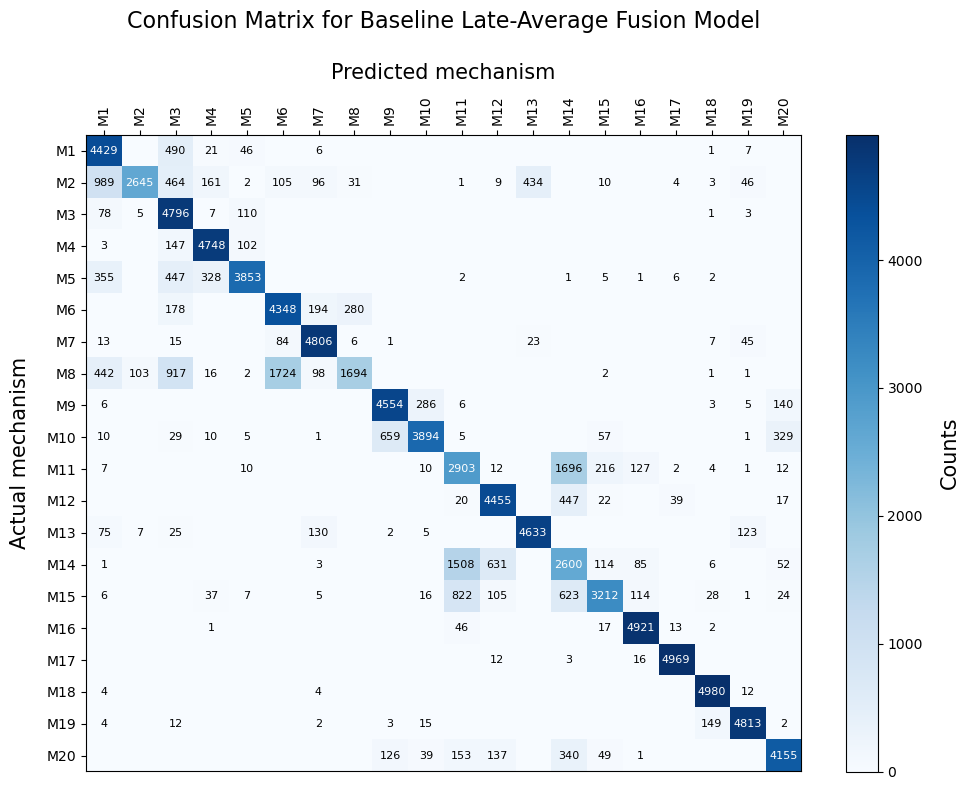

In [19]:
def plot_confusion_matrix_baseline(mean_probs, y_true, title=""):
    if y_true.ndim == 2:
        y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(mean_probs, axis=1)
    K = mean_probs.shape[1]
    cm = np.zeros((K, K), dtype=int)
    np.add.at(cm, (y_true, y_pred), 1)

    labels = [f"M{i}" for i in range(1, K+1)]
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, cmap="Blues", aspect="auto")
    plt.colorbar(im, ax=ax).set_label("Counts", fontsize=15, labelpad=12)
    ax.set_xticks(np.arange(K)); ax.set_yticks(np.arange(K))
    ax.set_xticklabels(labels, rotation=90);
    ax.set_yticklabels(labels)
    ax.xaxis.tick_top(); ax.xaxis.set_label_position('top')
    ax.set_xlabel("Predicted mechanism", fontsize=15, labelpad=12); 
    ax.set_ylabel("Actual mechanism", fontsize=15, labelpad=12); 
    ax.set_title(title, fontsize=16, pad=25)
    vmax = cm.max(); thresh = vmax/2 if vmax>0 else 0
    for i in range(K):
        for j in range(K):
            if cm[i, j] > 0:
                ax.text(j, i, cm[i, j], ha="center", va="center",
                        color=("white" if cm[i, j] > thresh else "black"),
                        fontsize=8)
    fig.tight_layout(); plt.show()

d = np.load("results_softmax_analysis/results_softmax_analysis_baseline.npz", allow_pickle=True)
mean_probs = d["mean_probs"]
plot_confusion_matrix_baseline(mean_probs, y_true, title="Confusion Matrix for Baseline Late-Average Fusion Model")

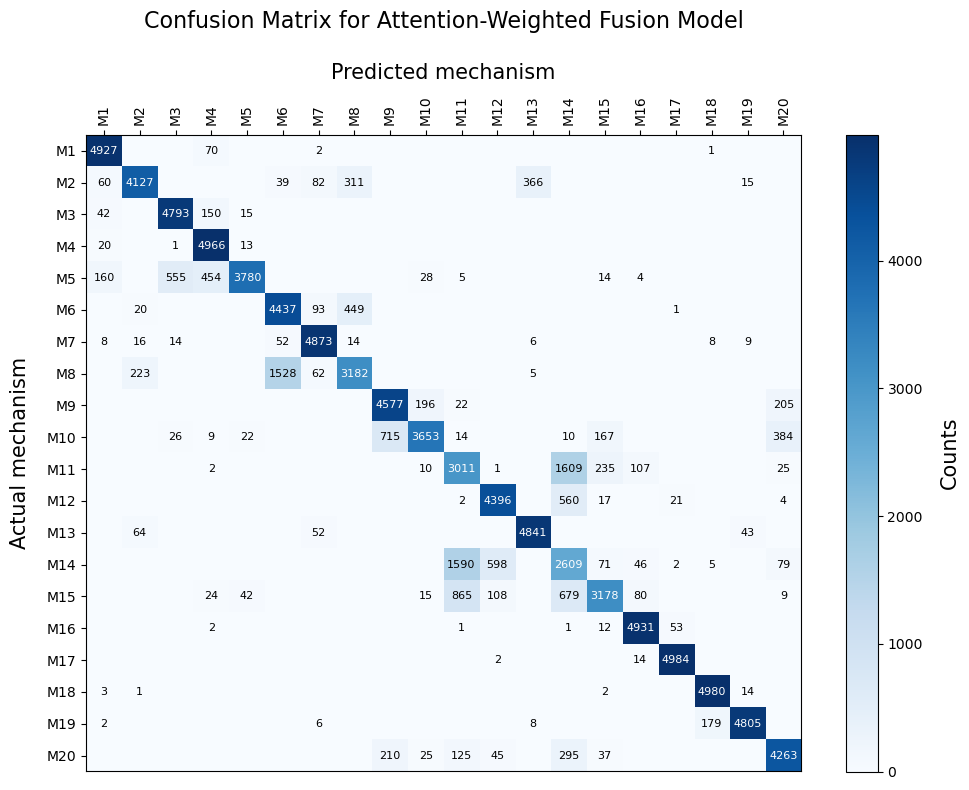

In [35]:
def plot_confusion_matrix_attention(mean_probs, y_true, title=""):
    if y_true.ndim == 2:
        y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(mean_probs, axis=1)
    K = mean_probs.shape[1]
    cm = np.zeros((K, K), dtype=int)
    np.add.at(cm, (y_true, y_pred), 1)

    labels = [f"M{i}" for i in range(1, K+1)]
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, cmap="Blues", aspect="auto")
    plt.colorbar(im, ax=ax).set_label("Counts", fontsize=15, labelpad=12)
    ax.set_xticks(np.arange(K)); ax.set_yticks(np.arange(K))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    ax.xaxis.tick_top(); ax.xaxis.set_label_position('top')
    ax.set_xlabel("Predicted mechanism", fontsize=15, labelpad=12)
    ax.set_ylabel("Actual mechanism", fontsize=15, labelpad=12)
    ax.set_title(title, fontsize=16, pad=25)
    vmax = cm.max(); thresh = vmax/2 if vmax > 0 else 0
    for i in range(K):
        for j in range(K):
            if cm[i, j] > 0:
                ax.text(j, i, cm[i, j], ha="center", va="center",
                        color=("white" if cm[i, j] > thresh else "black"),
                        fontsize=8)
    fig.tight_layout()
    plt.show()

d = np.load("results_softmax_analysis/results_softmax_analysis_attention.npz", allow_pickle=True)
mean_probs = d["mean_probs"]
plot_confusion_matrix_attention(mean_probs, y_true, title="Confusion Matrix for Attention-Weighted Fusion Model")

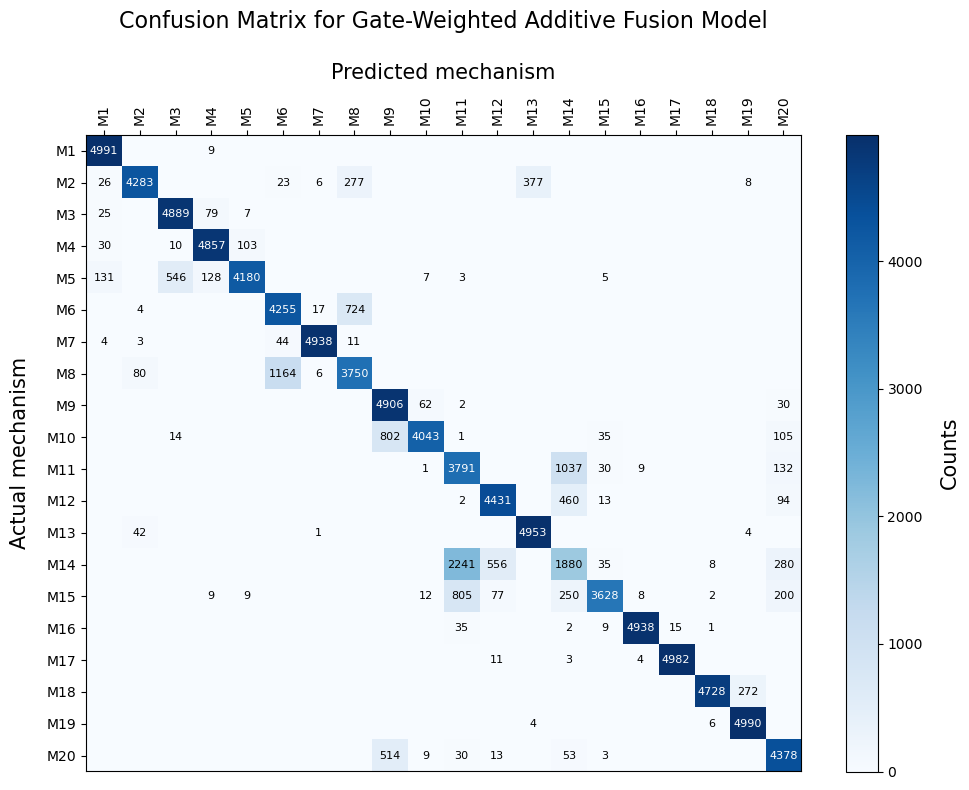

In [27]:
def plot_confusion_matrix_gating(mean_probs, y_true, title=""):
    if y_true.ndim == 2:
        y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(mean_probs, axis=1)
    K = mean_probs.shape[1]
    cm = np.zeros((K, K), dtype=int)
    np.add.at(cm, (y_true, y_pred), 1)

    labels = [f"M{i}" for i in range(1, K+1)]
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, cmap="Blues", aspect="auto")
    plt.colorbar(im, ax=ax).set_label("Counts", fontsize=15, labelpad=12)
    ax.set_xticks(np.arange(K)); ax.set_yticks(np.arange(K))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    ax.xaxis.tick_top(); ax.xaxis.set_label_position('top')
    ax.set_xlabel("Predicted mechanism", fontsize=15, labelpad=12)
    ax.set_ylabel("Actual mechanism", fontsize=15, labelpad=12)
    ax.set_title(title, fontsize=16, pad=25)
    vmax = cm.max(); thresh = vmax/2 if vmax > 0 else 0
    for i in range(K):
        for j in range(K):
            if cm[i, j] > 0:
                ax.text(j, i, cm[i, j], ha="center", va="center",
                        color=("white" if cm[i, j] > thresh else "black"),
                        fontsize=8)
    fig.tight_layout()
    plt.show()


d = np.load("results_softmax_analysis/results_softmax_analysis_gatefusion.npz", allow_pickle=True)
mean_probs = d["mean_probs"]
plot_confusion_matrix_gating(mean_probs, y_true, title="Confusion Matrix for Gate-Weighted Additive Fusion Model")

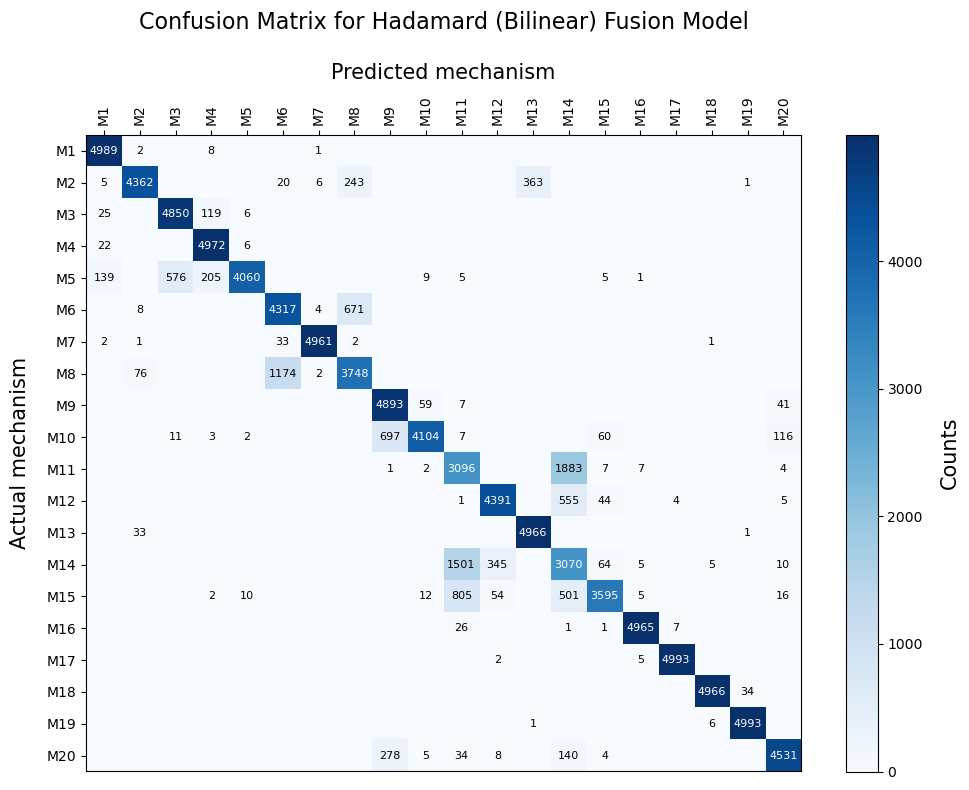

In [31]:
def plot_confusion_matrix_hadanard(mean_probs, y_true, title=""):
    if y_true.ndim == 2:
        y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(mean_probs, axis=1)
    K = mean_probs.shape[1]
    cm = np.zeros((K, K), dtype=int)
    np.add.at(cm, (y_true, y_pred), 1)

    labels = [f"M{i}" for i in range(1, K+1)]
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, cmap="Blues", aspect="auto")
    plt.colorbar(im, ax=ax).set_label("Counts", fontsize=15, labelpad=12)
    ax.set_xticks(np.arange(K)); ax.set_yticks(np.arange(K))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    ax.xaxis.tick_top(); ax.xaxis.set_label_position('top')
    ax.set_xlabel("Predicted mechanism", fontsize=15, labelpad=12)
    ax.set_ylabel("Actual mechanism", fontsize=15, labelpad=12)
    ax.set_title(title, fontsize=16, pad=25)
    vmax = cm.max(); thresh = vmax/2 if vmax > 0 else 0
    for i in range(K):
        for j in range(K):
            if cm[i, j] > 0:
                ax.text(j, i, cm[i, j], ha="center", va="center",
                        color=("white" if cm[i, j] > thresh else "black"),
                        fontsize=8)
    fig.tight_layout()
    plt.show()


d = np.load("results_softmax_analysis/results_softmax_analysis_hadamard.npz", allow_pickle=True)
mean_probs = d["mean_probs"]
plot_confusion_matrix_hadanard(mean_probs, y_true, title="Confusion Matrix for Hadamard (Bilinear) Fusion Model")